In [150]:
#base
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
#keras
import keras.backend as K
import tensorflow as tf 
from tensorflow.keras import losses
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
#sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from scipy.spatial import distance
from scipy.stats import spearmanr


In [2]:
warnings.filterwarnings('ignore')
sns.set_theme()

In [3]:
%cd /home/MCB/zkarwowska/AE

/home/MCB/zkarwowska/AE


In [4]:
def filter_rare_bacteria(df):
    
    rare_bacteria_df = pd.DataFrame((df == 0).astype(int).sum(axis = 0))
    rare_bacteria_col = rare_bacteria_df[rare_bacteria_df[0] > 250].index
    df_filtered = df.drop(rare_bacteria_col, axis = 1)
    
    return df_filtered

In [5]:
def history_to_df(results):
    
    results_df = pd.DataFrame.from_dict(results.history)
    results_df.columns = ['loss', 'val_loss']
    results_df['epoch'] = results_df.index
    
    return results_df

def plot_history(results_df):
    
    sns.lineplot(x = results_df['epoch'], y = results_df['loss'], color = 'black')
    sns.lineplot(x = results_df['epoch'], y = results_df['val_loss'], color = 'orange', linestyle = '--')
    
    b = mpatches.Patch(color='black', label='train')
    o = mpatches.Patch(color='orange', label='test')

    plt.legend(handles=[b, o], shadow = False)

    plt.show()

In [146]:
def calculate_BC(HISTORY, PREDICTION):
    
    PREDICTION.index = HISTORY.index
    
    BRAY_CURTIS = []

    for idx in HISTORY.index:

        y_true = HISTORY.loc[idx]
        y_forecasted = PREDICTION.loc[idx]

        bray_curtis = distance.braycurtis(y_true,
                                          y_forecasted)

        BRAY_CURTIS.append(bray_curtis)

    bray_curtis_df = pd.DataFrame(BRAY_CURTIS,
                              columns = ['bc_distance'])

    bray_curtis_df['timestep'] = HISTORY.index
    
    return bray_curtis_df


def calculate_spearman_rho(PREDICTION, HISTORY):
    
    RHO_imputed = []
    PVAL = []

    for col in HISTORY.columns:
        x = HISTORY[col]
        y = PREDICTION[col]

        rho, pval = spearmanr(x, y)
        RHO_imputed.append(rho)
    

    rho = pd.DataFrame(RHO_imputed, columns = ['rho'])
    rho['otu'] = HISTORY.columns
    
    return rho

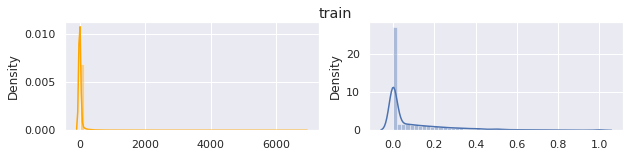

<Figure size 432x288 with 0 Axes>

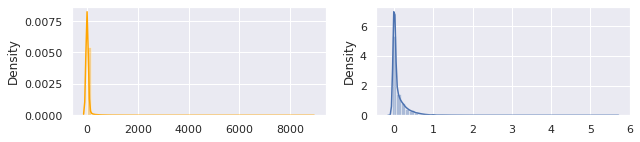

In [9]:
#read data
df = pd.read_csv('rarefied_double_interpolated_feces_male_otu.csv', index_col =[0])
filtered_df = filter_rare_bacteria(df)
filtered_df = filtered_df.drop(['TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGTGCGTAGACGGGAAAACAAGTTAGTTGTGAAATCCCTCGGCTTAACTGAGGAACTG',
                                'TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGAATGCAAGTCAGATGTGAAATCCATGGGCTTAACCCATGAACTG',
                               'TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGAATGCAAGTCAGATGTGAAATCCATGGGCTTAACCCATGAACTG',
                               'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTG'], axis = 1)

#split to train and test
x_train = filtered_df.iloc[:220]
x_test = filtered_df.iloc[221:]
#scale
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(x_train)
normalized_test = scaler.transform(x_test)

#plot distribution after scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 2])
plt.suptitle('train')
ax1 = sns.distplot(x_train, ax = ax1, color = 'orange')
ax2 = sns.distplot(normalized_train, ax = ax2)
plt.show()

plt.suptitle('test')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 2])
ax1 = sns.distplot(x_test, ax = ax1, color = 'orange')
ax2 = sns.distplot(normalized_test, ax = ax2)
plt.show()

In [10]:
class LossBrayCurtis(losses.Loss):

    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossBrayCurtis, self).__init__(name='bray_curtis')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        y_true = (y_true - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = (y_pred - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = tf.nn.relu(y_pred)


        diff = tf.math.abs(y_true - y_pred)
        sum = tf.math.abs(y_true + y_pred)
        value = tf.reduce_sum(diff, axis=-1) / tf.reduce_sum(sum, axis=-1)
        return value
    
    
class LossMAE(losses.Loss):

    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossMAE, self).__init__(name='mean_absolute_error')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        y_true = (y_true - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = (y_pred - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = tf.nn.relu(y_pred)


        diff = tf.math.abs(y_true - y_pred)
        value = tf.math.reduce_mean(diff, axis=1)
        
        return value

# predictive autoencoder with MAE loss and global weights

In [28]:
class Metrics(tf.keras.callbacks.Callback):
    
    def __init__(self, validation_data, scaler, prefix = 'val'):
        self.validation_data = validation_data #podpinamy validation data
        self.scaler = scaler
        self.prefix = prefix
        
        metrics_dict = {}

    def on_epoch_end(self, batch, logs={}):
        
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        
        predict_denorm = scaler.inverse_transform(predict)
        target_denrom = scaler.inverse_transform(targ)
        
        logs[f'{self.prefix}_cosine_distance'] = np.array([distance.cosine(target_denrom[i], predict_denorm[i]) for i in range(target_denrom.shape[0])]).mean()
        logs[f'{self.prefix}_bray_curtis'] = np.array([distance.braycurtis(target_denrom[i], predict_denorm[i]) for i in range(target_denrom.shape[0])]).mean()
        
        
        return

In [152]:
l_neurons = 32
h_neurons = 256

input_size = normalized_train.shape[1]
input_data = tf.keras.Input(shape=(input_size,))

encoder_layer = tf.keras.layers.Dense(h_neurons, activation='relu')
enoded = encoder_layer(input_data)

latent_layer = tf.keras.layers.Dense(l_neurons)
latent = latent_layer(enoded)

decoder_layer = tf.keras.layers.Dense(h_neurons, activation='relu')
decoded_reconstruction = decoder_layer(latent)

otuput_reconstruction = tf.keras.layers.Dense(input_size)(decoded_reconstruction)
autoencoder = tf.keras.Model(input_data, otuput_reconstruction)

BrayCurtisLoss = LossBrayCurtis(None, None)
MAEloss = LossMAE(None, None)

autoencoder.compile(
    loss = BrayCurtisLoss,   
    optimizer=tf.keras.optimizers.Adam()
)

autoencoder.run_eagerly = True
metrics = Metrics(validation_data = (normalized_test[:-1], normalized_test[1:]), scaler=scaler, prefix='val')
train_metrics = Metrics(validation_data = (normalized_train[:-1], normalized_train[1:]), scaler=scaler, prefix = 'train')

ae_result = autoencoder.fit(
    normalized_train[:-1], normalized_train[1:],
    epochs=100,
    batch_size=32,
    shuffle=False,
    validation_data=(normalized_test[:-1], normalized_test[1:]),
    verbose = 0,
    callbacks = [train_metrics, metrics]
)

In [117]:
results_df = pd.DataFrame(ae_result.history)
results_df['epoch'] = results_df.index

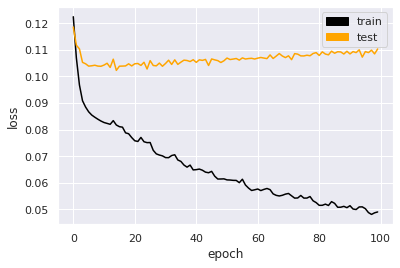

In [75]:
sns.lineplot(data = results_df, x = 'epoch', y = 'loss', color = 'black')
sns.lineplot(data = results_df, x = 'epoch', y = 'val_loss', color = 'orange')

b = mpatches.Patch(color='black', label='train')
o = mpatches.Patch(color='orange', label='test')

plt.legend(handles=[b, o], shadow = False)
plt.savefig('ae_svar/predictive_autoencoder/loss_mae_loss.png')

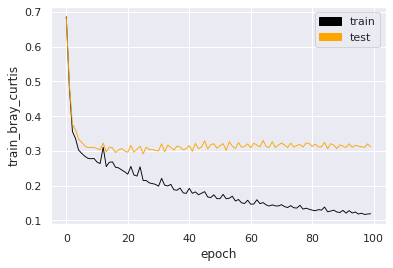

In [76]:
sns.lineplot(data = results_df, x = 'epoch', y = 'train_bray_curtis', color = 'black', linewidth = .9)
sns.lineplot(data = results_df, x = 'epoch', y = 'val_bray_curtis', color = 'orange', linewidth = .9)

b = mpatches.Patch(color='black', label='train')
o = mpatches.Patch(color='orange', label='test')

plt.legend(handles=[b, o], shadow = False)
plt.savefig('ae_svar/predictive_autoencoder/bc_metric_mae_loss.png')

In [153]:
prediction_encoder, prediction_decoder = extract_encoder_decoder(latent, 32, autoencoder)
train_recon = predict_data(prediction_encoder, prediction_decoder, normalized_train)
test_recon = predict_data(prediction_encoder, prediction_decoder, normalized_test)

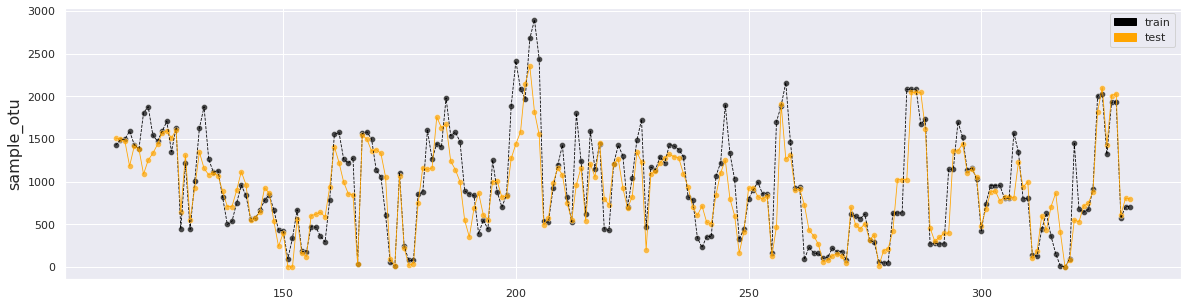

In [79]:
plot_sample_otu(x_train[1:],
                train_recon[:-1],
                'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGTTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG')
b = mpatches.Patch(color='black', label='train')
o = mpatches.Patch(color='orange', label='test')

plt.legend(handles=[b, o], shadow = False)
plt.savefig('ae_svar/predictive_autoencoder/train_prediction_mae_loss.png')

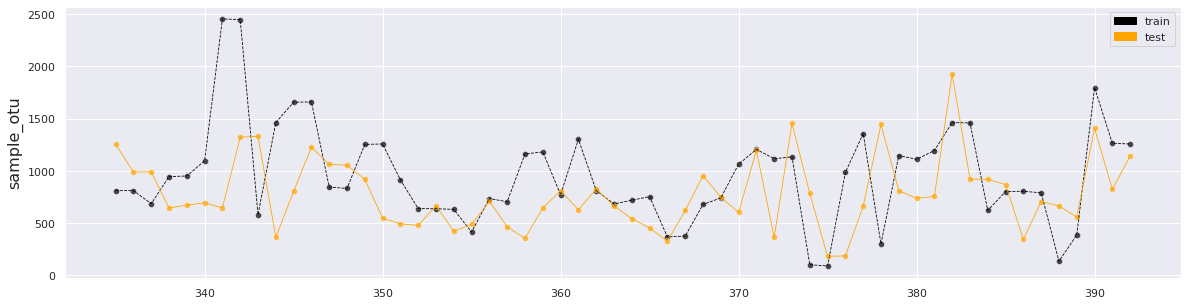

In [80]:
plot_sample_otu(x_test[1:],
                test_recon[:-1],
                'TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCGGGTTGTTAAGTCAGTTGTGAAAGTTTGCGGCTCAACCGTAAAATTG')
b = mpatches.Patch(color='black', label='train')
o = mpatches.Patch(color='orange', label='test')

plt.legend(handles=[b, o], shadow = False)
plt.savefig('ae_svar/predictive_autoencoder/test_prediction_mae_loss.png')